### Importing Bibs

In [1]:
# append src path to modules
import sys
import os
sys.path.append("../") # go to parent dir

# import sub-modules
import src.constants as co
import src.data.utils as du
import src.features.utils as fu
import src.models.utils as mu
import src.visualization.utils as vu

# further libraries
# dealing with package warnings
import warnings
#progress bar
from tqdm import tqdm
# environment variables

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# supress warning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

Import form src.constants is working
Import form src.data.utils is working
Import form src.features.utils is working
Import form src.models.utils is working
Import form src.visualization.utils is working


### Constants

In [2]:
#--------- handle the folders and files ---------#
FIG_DIR = "D:\\work-hsu\\08_code_programms\\ai-in-production-example-development\\use-case-2\\reports\\figures"

#--------- file constants related to JSON Object and dictionary---------#
# file items 
FILE_NAME = "FILE_NAME"
FILE_PATH = "FILE_PATH"
FILE_TYPE = "FILE_TYPE"
FILE_FOLDER = "FILE_FOLDER"
FILE_DEVICES = "FILE_DEVICES"
# device items
SAMPLE_TIME = "SAMPLE_TIME"
CHANNEL_DESCRIPTIONS = "CHANNEL_DESCRIPTIONS"
SAMPLES = "SAMPLES"
# sample items
EC_SYSTEM_TIMESTAMP = "EC_SYSTEM_TIMESTAMP"
CHANNEL_DATA = "CHANNEL_DATA"
SCALED_CHANNEL_DATA = "SCALED_CHANNEL_DATA"
# setable lables
WEIGHT_LABEL = "WEIGHT_LABEL"
FREQUENCY_LABEL = "FREQUENCY_LABEL"
MOVING_LABEL = "MOVING_LABEL"
# device name
DEVICE = "DEVICE"
DEVICE_DATA_FRAME = "DEVICE_DATA_FRAME"

### Converting raw data into data file

In [3]:
RAW_DATA_DIR = "D:\\work-hsu\\08_code_programms\\ai-in-production-example-development\\use-case-2\\data\\raw"
PROCESSED_DATA_DIR = "D:\\work-hsu\\08_code_programms\\ai-in-production-example-development\\use-case-2\\data\\processed"

DATA_FILE_NAME = "raw_data_frame"

# list of files with JSON data
files_list = du.parse_files(RAW_DATA_DIR, recursive=True)

#--------- create the dictionary with raw data ---------#
data_dict = du.create_data_dict(files_list)

# creating the data frames and Extend Dictionaries
print("Creating Data Frames:")
for file_dict in tqdm(data_dict.values(), desc="Data Frame"):
    #crreate and insert dataframe of device data (time series data)
    for device_dict in file_dict[FILE_DEVICES].values():
        du.create_dict_item(device_dict, DEVICE_DATA_FRAME, du.create_data_frame(device_dict))
    # create and append weight label (kg)
    du.create_dict_item(file_dict, WEIGHT_LABEL, du.get_weight_label(file_dict[FILE_FOLDER]))
    # create and append freq label (herz)
    du.create_dict_item(file_dict, FREQUENCY_LABEL, du.get_frequency_label(file_dict[FILE_FOLDER]))
    # create and append moving label (up down)
    for device_dict in file_dict[FILE_DEVICES].values():
        #device_data_frame = create_data_frame(device_dict)
        moving_label = du.get_moving_label(device_dict[DEVICE_DATA_FRAME], device_dict[DEVICE_DATA_FRAME].columns[3])
    du.create_dict_item(file_dict, MOVING_LABEL, moving_label)

#--------- features ---------#
print("Creating Feature Frames:")
feature_frame = du.create_feature_frame(data_dict)

#example for selection of data of the frame
#test_select = feature_frame[feature_frame["MOVING_LABEL"]=="up"]

du.save_file(feature_frame, PROCESSED_DATA_DIR, DATA_FILE_NAME, "pickle")

Name of File Path: D:\work-hsu\08_code_programms\ai-in-production-example-development\use-case-2\data\raw\**\*.json
Number of Files Parsed: 10
Creating Data Frames:


Data Frame: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Creating Feature Frames:


Feature Frame: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


### Printing the raw data

Creating Plot: 4it [00:00, 49.00it/s]
C:\Users\Schieseck\AppData\Local\Temp\ipykernel_21584\634092781.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\Schieseck\AppData\Local\Temp\ipykernel_21584\634092781.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


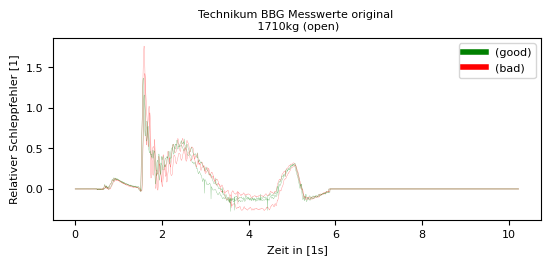

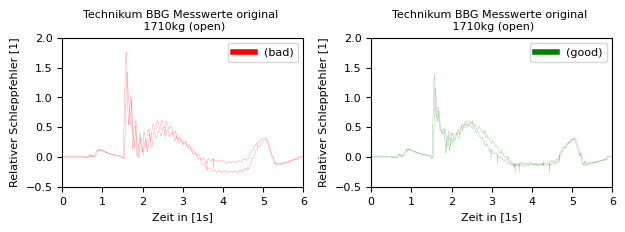

In [4]:
DATA_FILE_PATH = f"D:\\work-hsu\\08_code_programms\\ai-in-production-example-development\\use-case-2\\data\processed\\{DATA_FILE_NAME}.pickle"

# load data frame for printing
data_frame = du.load_file(DATA_FILE_PATH)

# selecting data were mass moves upwards and weights 1710kg
select_data = data_frame[(data_frame[du.MOVING_LABEL]=="up") & (data_frame[du.WEIGHT_LABEL]== 1710)]

FIG_WIDTH = vu.cm2in(16)
FIG_HEIGHT = vu.cm2in(6)


# begin the first printing figure
fig1, ax1 = plt.subplots(1,1, figsize=(FIG_WIDTH ,FIG_HEIGHT))

# figure were both axis are in different graphs
fig2, (ax2, ax3) = plt.subplots(1,2, figsize=(FIG_WIDTH ,FIG_HEIGHT), tight_layout=True)

for index, row in tqdm(select_data.iterrows(), desc="Creating Plot"):
    column_names = row[du.DEVICE_DATA_FRAME].columns
    x_col = column_names[0]
    y_col = column_names[5]
    y_values = row[du.DEVICE_DATA_FRAME][y_col]
    x_values = row[du.DEVICE_DATA_FRAME][x_col].subtract(row[du.DEVICE_DATA_FRAME][x_col].iloc[0]).divide(1e9)
    # set the printing color
    if row[du.FREQUENCY_LABEL] == 60:
        temp_color = "r"
        temp_custom_label = "(bad)"
        vu.custom_plot(ax2, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25, 
                        autoscale = False, x_limits=(0, 6), y_limits=(-0.5, 2), 
                        title="Technikum BBG Messwerte original \n 1710kg (open)", x_label= "Zeit in [1s]", y_label="Relativer Schleppfehler [1]",
                        plot_custom_legend = True, custom_label = temp_custom_label)
    if row[du.FREQUENCY_LABEL] == 69:
        temp_color = "g"
        temp_custom_label = "(good)"
        vu.custom_plot(ax3, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25, 
                        autoscale = False, x_limits=(0, 6), y_limits=(-0.5, 2),
                        title = "Technikum BBG Messwerte original \n 1710kg (open)", x_label= "Zeit in [1s]", y_label="Relativer Schleppfehler [1]",
                        plot_custom_legend = True, custom_label = temp_custom_label)

    vu.custom_plot(ax1, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25,
                    title = "Technikum BBG Messwerte original \n 1710kg (open)", x_label="Zeit in [1s]", y_label="Relativer Schleppfehler [1]",
                    plot_custom_legend=True, custom_label=temp_custom_label)

vu.save_fig(fig1, FIG_DIR, "raw_common", overwrite=True)
vu.save_fig(fig2, FIG_DIR, "raw_seperate", overwrite=True)

fig1.show()
fig2.show()

### Preprocess the Data

In [5]:
#file name
FEATURE_FILE_NAME = "feature_frame"

# settings of the preprocessing
RESAMPLETIME = '0.05s'
MIN_ELEMENTS = 0
MAX_ELEMENTS = 100

data_frame = du.load_file(DATA_FILE_PATH)
#resample and cutting
drop_list = []
for index, row in data_frame.iterrows():
        try:
            # if any None, NaN etc. than raise the exception
            if row["DEVICE_DATA_FRAME"].isnull().values.any() == True:
                raise
            # convert to datetime
            row["DEVICE_DATA_FRAME"]["EC_SYSTEM_TIMESTAMP"] = pd.to_datetime(row["DEVICE_DATA_FRAME"]["EC_SYSTEM_TIMESTAMP"], unit = "ns")
            # resample 
            row["DEVICE_DATA_FRAME"] = row["DEVICE_DATA_FRAME"].resample(RESAMPLETIME, on="EC_SYSTEM_TIMESTAMP").mean()
            # reindexing 
            row["DEVICE_DATA_FRAME"].reset_index(inplace=True)
            # convert with pos interval
            row["DEVICE_DATA_FRAME"] = row["DEVICE_DATA_FRAME"][(row["DEVICE_DATA_FRAME"]['Aktueller Wert / DigitalausgÃ¤nge GrundgerÃ¤t ']==1)]
            # cut to 100
            row["DEVICE_DATA_FRAME"] = row["DEVICE_DATA_FRAME"][MIN_ELEMENTS:MAX_ELEMENTS]
            # reconvert to unix time
            row["DEVICE_DATA_FRAME"]["EC_SYSTEM_TIMESTAMP"] = row["DEVICE_DATA_FRAME"]["EC_SYSTEM_TIMESTAMP"].apply(lambda x: (x - pd.Timestamp("1970-01-01"))//pd.Timedelta("1ms"))

        except:
            # name dropping element
            print(f"Error with data row {index}, name: {row.FILE_NAME}")
            drop_list.append(f"{row.FILE_NAME}")
            print("Appended to drop list")

# drop elements of dataframe
for drop_element in drop_list:
    data_frame.drop(data_frame[data_frame.FILE_NAME == drop_element].index, inplace = True)
    print(f"Element {drop_element} dropped")

# file saving
du.save_file(data_frame, PROCESSED_DATA_DIR, FEATURE_FILE_NAME, "pickle")

Error with data row 2, name: 23_03_08_13_52_46_7b363fd453f842d79a13ff29b59a5739_42
Appended to drop list
Error with data row 6, name: 23_03_08_14_57_12_955675d4aebc4528a14633ab883b2311_182
Appended to drop list
Element 23_03_08_13_52_46_7b363fd453f842d79a13ff29b59a5739_42 dropped
Element 23_03_08_14_57_12_955675d4aebc4528a14633ab883b2311_182 dropped


### Printing preprocessed Data

Creating Plot 1: 3it [00:00, 230.59it/s]
C:\Users\Schieseck\AppData\Local\Temp\ipykernel_21584\3069357629.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\Schieseck\AppData\Local\Temp\ipykernel_21584\3069357629.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


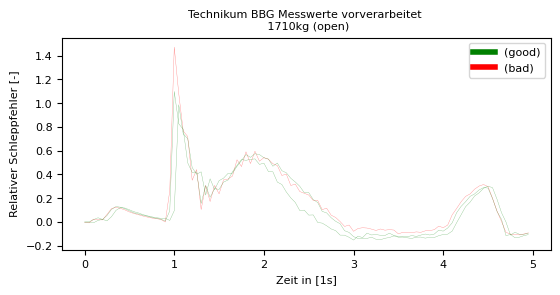

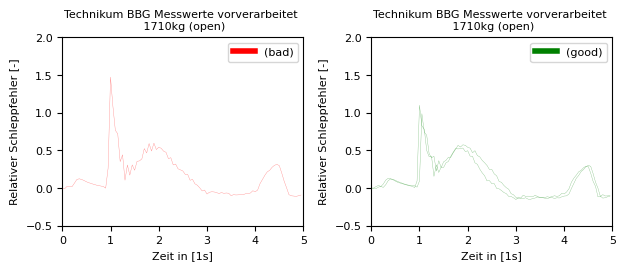

In [7]:
FEATURE_PATH= f"D:\\work-hsu\\08_code_programms\\ai-in-production-example-development\\use-case-2\\data\processed\\{FEATURE_FILE_NAME}.pickle"

FIG_WIDTH = vu.cm2in(16)
FIG_HEIGHT = vu.cm2in(7)

data_frame = du.load_file(FEATURE_PATH)

# selecting data were mass moves upwards and weights 1710kg
select_data = data_frame[(data_frame[du.MOVING_LABEL]=="up") & (data_frame[du.WEIGHT_LABEL]== 1710)]

# begin the first printing figure
fig1, ax1 = plt.subplots(1,1, figsize=(FIG_WIDTH, FIG_HEIGHT))

# figure were both axis are in different graphs
fig2, (ax2, ax3) = plt.subplots(1,2, figsize=(FIG_WIDTH, FIG_HEIGHT), tight_layout=True)

for index, row in tqdm(select_data.iterrows(), desc="Creating Plot 1"):
    column_names = row[du.DEVICE_DATA_FRAME].columns
    x_col = column_names[0]
    y_col = column_names[5]
    y_values = row[du.DEVICE_DATA_FRAME][y_col]
    x_values = row[du.DEVICE_DATA_FRAME][x_col].subtract(row[du.DEVICE_DATA_FRAME][x_col].iloc[0]).divide(1e3)
    # set the printing color
    if row[du.FREQUENCY_LABEL] == 60:
        temp_color = "r"
        temp_custom_label = "(bad)"
        vu.custom_plot(ax2, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25, 
                        autoscale = False, x_limits=(0, 5), y_limits=(-0.5, 2), 
                        title="Technikum BBG Messwerte vorverarbeitet \n 1710kg (open)", x_label= "Zeit in [1s]", y_label="Relativer Schleppfehler [-]",
                        plot_custom_legend = True, custom_label = temp_custom_label)
    if row[du.FREQUENCY_LABEL] == 69:
        temp_color = "g"
        temp_custom_label = "(good)"
        vu.custom_plot(ax3, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25, 
                        autoscale = False, x_limits=(0, 5), y_limits=(-0.5, 2),
                        title = "Technikum BBG Messwerte vorverarbeitet \n 1710kg (open)", x_label= "Zeit in [1s]", y_label="Relativer Schleppfehler [-]",
                        plot_custom_legend = True, custom_label = temp_custom_label)

    vu.custom_plot(ax1, x_values, y_values, alpha = 0.5, color = temp_color, linewidth = 0.25,
                    title = "Technikum BBG Messwerte vorverarbeitet \n 1710kg (open)", x_label= "Zeit in [1s]", y_label="Relativer Schleppfehler [-]",
                    plot_custom_legend=True, custom_label=temp_custom_label)

vu.save_fig(fig1, FIG_DIR, "processed_common", overwrite=True)
vu.save_fig(fig2, FIG_DIR, "processed_seperate", overwrite=True)

fig1.show()
fig2.show()